In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mugs-shapenet/c0c130c04edabc657c2b66248f91b3d8.glb
/kaggle/input/mugs-shapenet/f99e19b8c4a729353deb88581ea8417a.glb
/kaggle/input/mugs-shapenet/8f6c86feaa74698d5c91ee20ade72edc.glb
/kaggle/input/mugs-shapenet/b815d7e084a5a75b8d543d7713b96a41.glb
/kaggle/input/mugs-shapenet/e71102b6da1d63f3a363b55cbd344baa.glb
/kaggle/input/mugs-shapenet/bcb6be8f0ff4a51872e526c4f21dfca4.glb
/kaggle/input/mugs-shapenet/6e884701bfddd1f71e1138649f4c219.glb
/kaggle/input/mugs-shapenet/85d5e7be548357baee0fa456543b8166.glb
/kaggle/input/mugs-shapenet/1f035aa5fc6da0983ecac81e09b15ea9.glb
/kaggle/input/mugs-shapenet/9961ccbafd59cb03fe36eb2ab5fa00e0.glb
/kaggle/input/mugs-shapenet/ca198dc3f7dc0cacec6338171298c66b.glb
/kaggle/input/mugs-shapenet/6c04c2eac973936523c841f9d5051936.glb
/kaggle/input/mugs-shapenet/1bc5d303ff4d6e7e1113901b72a68e7c.glb
/kaggle/input/mugs-shapenet/8012f52dd0a4d2f718a93a45bf780820.glb
/kaggle/input/mugs-shapenet/128ecbc10df5b05d96eaf1340564a4de.glb
/kaggle/input/mugs-shapene

In [2]:
import random
mug_dir = "/kaggle/input/mugs-shapenet"
all_mugs = sorted(os.listdir(mug_dir))
random.seed(42)

SELECTED = all_mugs[:20]   

In [3]:
with open("/kaggle/working/selected_mugs.txt", "w") as f:
    for m in SELECTED:
        f.write(m + "\n")

In [4]:
!pip install trimesh pyrender rtree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.0/737.0 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.8 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=effa8da4d40ff97f5d66f4f48387605af864471b720b8f7e8f127f3bc5445a8d
  Stored in directory: /root/.cache/pip/wheels/5c/d0/77/e69597cdbcb72ea27345036f549a737909bcf17c39789472ce
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.10
    Uninstalling PyOpenGL-3.1.10:
      Successfully uninstalled PyOpenGL-3.1.10


In [11]:
import trimesh
import numpy as np

def load_and_normalize(path):
    mesh = trimesh.load(path, force='mesh')

    # Handle scenes
    if isinstance(mesh, trimesh.Scene):
        mesh = trimesh.util.concatenate(mesh.geometry.values())

    # ---- CLEAN MESH (KAGGLE SAFE) ----
    mesh.remove_unreferenced_vertices()

    # Remove NaNs / Infs
    mesh.vertices = mesh.vertices[np.isfinite(mesh.vertices).all(axis=1)]

    # Fix normals & topology
    mesh.process(validate=True)

    # Try filling holes (safe even if none)
    try:
        mesh.fill_holes()
    except:
        pass

    # Re-center mesh
    mesh.rezero()

    # Normalize to unit sphere
    scale = np.max(np.linalg.norm(mesh.vertices, axis=1))
    mesh.vertices /= scale

    return mesh

In [12]:
mesh = load_and_normalize(os.path.join(mug_dir, SELECTED[10]))
mesh.show()

In [13]:
import numpy as np
import trimesh

def sample_sdf(mesh, n_points=20000):
    """
    Efficient SDF sampling:
    - 70% near surface
    - 30% uniform
    """

    # --- near-surface samples ---
    surface_pts, _ = trimesh.sample.sample_surface(mesh, int(0.7 * n_points))
    noise = 0.01 * np.random.randn(*surface_pts.shape)
    near_pts = surface_pts + noise

    sdf_near = trimesh.proximity.signed_distance(mesh, near_pts)

    # --- uniform samples ---
    uniform_pts = np.random.uniform(-1.1, 1.1, size=(int(0.3 * n_points), 3))
    sdf_uniform = trimesh.proximity.signed_distance(mesh, uniform_pts)

    # --- combine ---
    pts = np.concatenate([near_pts, uniform_pts], axis=0)
    sdf = np.concatenate([sdf_near, sdf_uniform], axis=0)

    # clamp for DeepSDF stability
    sdf = np.clip(sdf, -0.1, 0.1)

    return pts.astype(np.float32), sdf.astype(np.float32)

In [ ]:
import torch

all_sdf = {}

for name in SELECTED:
    mesh = load_and_normalize(os.path.join(mug_dir, name))
    pts, sdf = sample_sdf(mesh)

    all_sdf[name] = {
        "points": pts,
        "sdf": sdf
    }

print("Prepared SDF for", len(all_sdf), "mugs")

KeyboardInterrupt: 

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class DeepSDF(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()

        self.fc1 = nn.Linear(3 + latent_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)

    def forward(self, x, z):
        h = torch.cat([x, z], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [27]:
LATENT_DIM = 64
NUM_SHAPES = len(SELECTED)

latent_codes = nn.Embedding(NUM_SHAPES, LATENT_DIM)
nn.init.normal_(latent_codes.weight, mean=0.0, std=0.01)

Parameter containing:
tensor([[-0.0012, -0.0192,  0.0089,  ..., -0.0072,  0.0092, -0.0158],
        [-0.0058, -0.0250,  0.0151,  ...,  0.0026,  0.0078, -0.0008],
        [-0.0003, -0.0147, -0.0111,  ..., -0.0366,  0.0180,  0.0167],
        ...,
        [ 0.0029,  0.0003,  0.0115,  ..., -0.0001, -0.0011,  0.0041],
        [-0.0028, -0.0264,  0.0014,  ..., -0.0107,  0.0047,  0.0161],
        [ 0.0013, -0.0129,  0.0082,  ..., -0.0113, -0.0129, -0.0050]],
       requires_grad=True)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DeepSDF(LATENT_DIM).to(device)
latent_codes = latent_codes.to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(latent_codes.parameters()),
    lr=1e-4
)

EPOCHS = 800
SAMPLES_PER_SHAPE = 4096
def latent_weight(epoch):
    return min(1e-4, epoch / 200 * 1e-4)

In [29]:
for epoch in range(EPOCHS):
    total_loss = 0.0

    for idx, name in enumerate(SELECTED):
        data = all_sdf[name]

        pts = torch.tensor(data["points"]).to(device)
        sdf_gt = torch.tensor(data["sdf"]).unsqueeze(1).to(device)

        sel = torch.randperm(len(pts))[:SAMPLES_PER_SHAPE]
        pts = pts[sel]
        sdf_gt = sdf_gt[sel]

        z = latent_codes(
            torch.tensor([idx], device=device)
        ).repeat(len(pts), 1)

        pred = model(pts, z)

        recon = torch.mean(torch.abs(pred - sdf_gt))
        reg = torch.mean(z.pow(2))
        loss = recon + latent_weight(epoch) * reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if epoch % 25 == 0:
        print(f"Epoch {epoch} | Loss {total_loss:.4f}")

KeyError: '1f035aa5fc6da0983ecac81e09b15ea9.glb'

In [22]:
torch.save({
    "model": model.state_dict(),
    "latents": latent_codes.state_dict(),
    "selected": SELECTED
}, "/kaggle/working/deepsdf_mugs.pth")

In [23]:
model.eval()
latent_codes.eval()

Embedding(20, 64)

In [29]:
selected_ids = [0, 2, 5, 7, 9, 12, 15, 18]

In [30]:
import numpy as np
import torch
from skimage import measure
import trimesh

def make_grid(res=128, bound=1.1):
    lin = np.linspace(-bound, bound, res)
    grid = np.stack(np.meshgrid(lin, lin, lin), -1)
    return grid.reshape(-1, 3), lin

In [31]:
def reconstruct_mesh(model, latent_codes, idx, res=128):
    model.eval()
    latent_codes.eval()

    grid, lin = make_grid(res)
    pts = torch.tensor(grid, device=device).float()

    z = latent_codes(
        torch.tensor([idx], device=device)
    ).repeat(len(pts), 1)

    with torch.no_grad():
        sdf = model(pts, z).cpu().numpy().reshape(res, res, res)

    verts, faces, normals, _ = measure.marching_cubes(
        sdf, level=0.0, spacing=(lin[1]-lin[0],)*3
    )

    return trimesh.Trimesh(verts, faces, normals, process=True)

In [32]:
for idx in selected_ids:
    mesh = reconstruct_mesh(model, latent_codes, idx, res=128)
    mesh.export(f"/kaggle/working/recon_mug_{idx}.obj")

In [34]:
mesh = reconstruct_mesh(model, latent_codes, selected_ids[1])
mesh.show()

In [39]:
import numpy as np
import trimesh
from scipy.spatial import cKDTree

def normalize_mesh(mesh):
    mesh = mesh.copy()
    center = mesh.bounds.mean(axis=0)
    scale = (mesh.bounds[1] - mesh.bounds[0]).max()
    mesh.vertices = (mesh.vertices - center) / scale
    return mesh


def sample_points(mesh, n=10000):
    return mesh.sample(n)


def chamfer_distance(mesh_a, mesh_b, n_points=10000):
    pts_a = sample_points(mesh_a, n_points)
    pts_b = sample_points(mesh_b, n_points)

    tree_a = cKDTree(pts_a)
    tree_b = cKDTree(pts_b)

    dist_a_to_b, _ = tree_b.query(pts_a)
    dist_b_to_a, _ = tree_a.query(pts_b)

    return dist_a_to_b.mean() + dist_b_to_a.mean()

In [40]:
chamfers = []

for idx in selected_ids:
    recon = reconstruct_mesh(model, latent_codes, idx)
    recon = normalize_mesh(recon)

    gt_path = f"/kaggle/input/mugs-shapenet/{SELECTED[idx]}"
    gt = trimesh.load(gt_path, force='mesh')
    if isinstance(gt, trimesh.Scene):
        gt = trimesh.util.concatenate(gt.geometry.values())

    gt = normalize_mesh(gt)

    cd = chamfer_distance(recon, gt)
    chamfers.append(cd)

    print(f"Mug {idx} | Chamfer Distance: {cd:.5f}")

Mug 0 | Chamfer Distance: 0.20687
Mug 2 | Chamfer Distance: 0.21121
Mug 5 | Chamfer Distance: 0.16466
Mug 7 | Chamfer Distance: 0.14822
Mug 9 | Chamfer Distance: 0.11524
Mug 12 | Chamfer Distance: 0.14297
Mug 15 | Chamfer Distance: 0.14129
Mug 18 | Chamfer Distance: 0.14275


In [46]:
mesh = reconstruct_mesh(model, latent_codes, selected_ids[0])
points = mesh.sample(6000)

In [47]:
pts = torch.tensor(points, device=device).float()
pts.requires_grad_(True)

z = latent_codes(
    torch.tensor([selected_ids[0]], device=device)
).repeat(len(pts), 1)

sdf = model(pts, z)

grads = torch.autograd.grad(
    sdf, pts,
    grad_outputs=torch.ones_like(sdf),
    create_graph=False
)[0]

In [48]:
normals = grads / (grads.norm(dim=1, keepdim=True) + 1e-6)

curvature = torch.norm(
    normals - normals.mean(dim=0, keepdim=True),
    dim=1,
    keepdim=True
)

In [49]:
centroid = pts.mean(dim=0, keepdim=True)
dist_center = torch.norm(pts - centroid, dim=1, keepdim=True)

In [53]:
features = torch.cat([
    pts * 0.5,                 # downweight position
    normals * 0.3,             # downweight normals
    curvature * 3.0,           # STRONGLY emphasize curvature
    dist_center * 2.0          # emphasize thin structures
], dim=1)

In [54]:
curv_thresh = torch.quantile(curvature, 0.65)
mask = curvature.squeeze() > curv_thresh

features_f = features[mask]
points_f = pts[mask]

from sklearn.cluster import KMeans

X = features_f.detach().cpu().numpy()
kmeans = KMeans(n_clusters=3, n_init=20, random_state=0)
labels = kmeans.fit_predict(X)

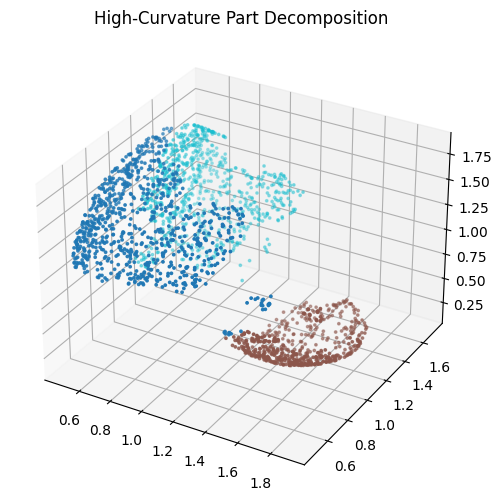

In [56]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    points_f[:, 0].detach().cpu().numpy(),
    points_f[:, 1].detach().cpu().numpy(),
    points_f[:, 2].detach().cpu().numpy(),
    c=labels,
    s=3,
    cmap='tab10'
)

ax.set_title("High-Curvature Part Decomposition")
plt.show()


In [57]:
HANDLE_CLUSTER = 2  # example, adjust based on visualization

In [58]:
handle_mask = labels == HANDLE_CLUSTER
handle_points = points_f[handle_mask]

In [59]:
scale_factor = 1.2  # 20% longer handle

edited_points = handle_points.clone()
edited_points[:, 0] *= scale_factor

In [69]:
model.eval()
for p in model.parameters():
    p.requires_grad = False

In [ ]:
edited_points = edited_points.detach().float().to(device)
edited_points.requires_grad = False


In [ ]:
z = z_init.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([z], lr=1e-3)

LAMBDA_ANCHOR = 1.0     # preserves body
LAMBDA_LATENT = 1e-3   # prevents extreme drift

for step in range(600):
    optimizer.zero_grad()

    # Handle constraint
    z_handle = z.expand(len(edited_points), -1)
    sdf_handle = model(edited_points, z_handle)
    loss_handle = torch.mean(torch.abs(sdf_handle))

    # Anchor constraint (body preservation)
    z_anchor_rep = z.expand(len(anchor_pts), -1)
    sdf_anchor = model(anchor_pts, z_anchor_rep)
    loss_anchor = torch.mean(torch.abs(sdf_anchor))

    # Latent regularization
    loss_latent = torch.mean((z - z_anchor)**2)

    # Total loss
    loss = (
        loss_handle
        + LAMBDA_ANCHOR * loss_anchor
        + LAMBDA_LATENT * loss_latent
    )

    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(
            f"Step {step} | "
            f"Handle {loss_handle.item():.4f} | "
            f"Anchor {loss_anchor.item():.4f} | "
            f"Latent {loss_latent.item():.6f}"
        )


In [77]:
model.eval()
latent_codes.eval()
for p in model.parameters():
    p.requires_grad = False
for p in latent_codes.parameters():
    p.requires_grad = False

In [79]:
orig_mesh = reconstruct_mesh(model, latent_codes, idx, res=128)
orig_mesh.export("/kaggle/working/original_mug.obj");

In [80]:
# z is already optimized
z_edited = z.detach()

def reconstruct_mesh_from_z(model, z, res=128):
    grid, lin = make_grid(res)
    pts = torch.tensor(grid, device=device).float()

    z_rep = z.expand(len(pts), -1)

    with torch.no_grad():
        sdf = model(pts, z_rep).cpu().numpy().reshape(res, res, res)

    verts, faces, normals, _ = measure.marching_cubes(
        sdf, level=0.0, spacing=(lin[1] - lin[0],)*3
    )

    return trimesh.Trimesh(verts, faces, normals, process=True)

In [82]:
edited_mesh = reconstruct_mesh_from_z(model, z_edited, res=128)
edited_mesh.export("/kaggle/working/edited_mug.obj");

In [86]:
import trimesh.viewer

print("Edited mesh")
edited_mesh.show()

Edited mesh
